In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import matplotlib

In [4]:
%matplotlib inline

In [5]:
from matplotlib import pyplot as plt
import palettable

In [6]:
import sys
import pathlib

### import the local package 

In [7]:
sys.path.append('../../')

In [8]:
import seaborn as sns

In [9]:
from ICU_Water_Watch import C3S, geo, plot, utils, verification, domains

In [10]:
from datetime import datetime, timedelta
from calendar import month_abbr

In [11]:
import numpy as np
import pandas as pd 
import xarray as xr

In [12]:
import cartopy.crs as ccrs 

In [13]:
from shapely.geometry import Point, Polygon
import regionmask

### climpred HindcastEnsemble Class

In [14]:
from climpred import HindcastEnsemble

### logging, to see what `climpred` is doing under the hood 

In [15]:
import logging
logger = logging.getLogger()

logger.setLevel(logging.INFO) # minimum and maximum bounds for initializations and verification dates

# logger.setLevel(logging.DEBUG) # every single initialisation and verif date used 

### progress bar for dask compute 

In [16]:
from dask.diagnostics import ProgressBar

In [17]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

### path definitions 

In [18]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [19]:
fig_path = CWD.joinpath('figures_paper')

In [20]:
fig_path

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/notebooks/verification/figures_paper')

### domain for the calculation of the ACC 

In [21]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [125, 240, -35, 25]}

In [22]:
domain_name = 'Water_Watch'

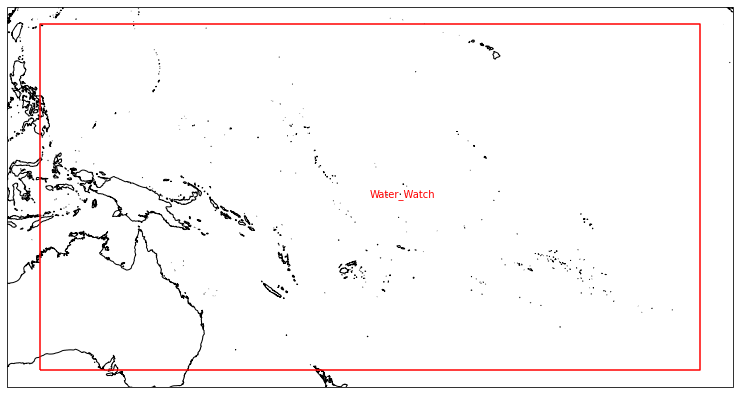

In [23]:
f = domains.plot_domains(domain_name=domain_name)

In [24]:
domain = domains.domains[domain_name]

In [25]:
domain

[125, 240, -35, 25]

### verification dataset 

In [26]:
use_verif = 'era'

In [27]:
GCMs = ['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP', 'JMA']

In [28]:
varname = 'tprate'

In [29]:
period = 'seasonal'

In [30]:
year_start = 1993 
year_end = 2016

In [31]:
if use_verif == 'gpcp': 
    dset_obs, dset_anoms = verification.get_gpcp()
    del(dset_anoms)
    dset_obs = utils.interp_to_1x(dset_obs)
    dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))
    
if use_verif == 'cmap': 
    dset_obs, dset_anoms = verification.get_cmap()
    del(dset_anoms)
    dset_obs = utils.interp_to_1x(dset_obs)
    dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))
    
elif use_verif == 'mswep': 
    dset_obs, dset_anoms = verification.get_mswep()
    del(dset_anoms)
    dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))
    
elif use_verif == 'era': 
    dset_obs, dset_anoms = verification.get_era5()
    del(dset_anoms)
    dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))    

### get rid of the junk 

In [32]:
for jvar in ['lat_bnds', 'lon_bnds']:
    if jvar in dset_obs.data_vars: 
        dset_obs = dset_obs.drop(jvar)

In [33]:
period

'seasonal'

In [34]:
if period == 'seasonal': 
    dset_obs = dset_obs.rolling({'time':3}, min_periods=3).mean('time')
    dset_obs = dset_obs.isel(time=slice(2, None))

In [35]:
dset_obs

<xarray.Dataset>
Dimensions:  (time: 286, lat: 61, lon: 116)
Coordinates:
  * time     (time) datetime64[ns] 1993-03-01 1993-04-01 ... 2016-12-01
  * lat      (lat) float64 -35.0 -34.0 -33.0 -32.0 -31.0 ... 22.0 23.0 24.0 25.0
  * lon      (lon) float64 125.0 126.0 127.0 128.0 ... 237.0 238.0 239.0 240.0
Data variables:
    precip   (time, lat, lon) float64 dask.array<chunksize=(1, 61, 116), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-21 14:37:06 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [36]:
GCMs

['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP', 'JMA']

### Now try the same for the MME 

In [37]:
MME  = []
for GCM in GCMs:  
    gcm = C3S.get_one_GCM(GCM=GCM, anomalies=False, ensemble_mean=False)
    if period == 'seasonal': 
        gcm = gcm.rolling({'step':3}, min_periods=3).mean('step')
        gcm = gcm.sel(step=slice(3, None))
    gcm = gcm.expand_dims({'GCM':[GCM]})
    MME.append(gcm)

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/ECMWF/TPRATE
reading 288 files

first: /media/nicolasf/END19101/ICU/data/CDS/ECMWF/TPRATE/ensemble_seas_forecasts_tprate_from_1993_01_ECMWF.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/ECMWF/TPRATE/ensemble_seas_forecasts_tprate_from_2016_12_ECMWF.netcdf

unit is m s**-1, converting to mm/day

now converting to mm/month, converted precipitation will be held in var = precip
getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/UKMO/TPRATE
reading 287 files

first: /media/nicolasf/END19101/ICU/data/CDS/UKMO/TPRATE/ensemble_seas_forecasts_tprate_from_1993_02_UKMO.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/UKMO/TPRATE/ensemble_seas_forecasts_tprate_from_2016_12_UKMO.netcdf

unit is m s**-1, converting to mm/day

now converting to mm/month, converted precipitation will be held in var = precip
getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/METEO_FRANCE/TPRATE
reading 288 files

first: /media/nicolasf

### concatenate over the GCM dimension 

In [38]:
MME = xr.concat(MME, dim='GCM')

### process for climpred 

In [39]:
hindcast_MME = verification.process_for_climpred(MME)

### creates a hindcast ensemble 

In [40]:
hindcast_MME = HindcastEnsemble(hindcast_MME)

### adds the 'observations' to the hindcast ensemble

In [41]:
hindcast_MME = hindcast_MME.add_observations(dset_obs)

/home/nicolasf/mambaforge/envs/ICU_ops/lib/python3.9/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


### terciles or quartiles 

In [42]:
q = [1/3., 2/3.]
# q = [0.2500, 0.5000, 0.7500]

### forecast edges 

In [43]:
forecast_edges = (

    hindcast_MME.get_initialized()

    .groupby("init.month")

    .quantile(q=q, dim=["init", "member"])

    .rename({"quantile": "category_edge"})

)

In [44]:
forecast_edges

<xarray.Dataset>
Dimensions:        (GCM: 7, lon: 121, lat: 81, lead: 3, month: 12,
                    category_edge: 2)
Coordinates:
  * GCM            (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' ... 'NCEP' 'JMA'
  * lon            (lon) float32 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
  * lat            (lat) float32 -50.0 -49.0 -48.0 -47.0 ... 27.0 28.0 29.0 30.0
  * lead           (lead) int64 3 4 5
  * category_edge  (category_edge) float64 0.3333 0.6667
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip         (month, category_edge, GCM, lead, lat, lon) float64 91.87 ...

### rechunk the hindcast MME 

In [46]:
hindcast_MME.chunks

Frozen({'time': (1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3), 'lat': (61,), 'lon': (116,)})

In [49]:
hindcast_MME = hindcast_MME.chunk(dict(time=-1, lat=1, lon=1))

### observations edges 

In [50]:
obs_edges = (

    hindcast_MME.get_observations()

    .groupby("time.month")

    .quantile(q=q, dim="time")

    .rename({"quantile": "category_edge"})

)

### put the observations then the forecast edges, in a tuple

In [51]:
category_edges = (obs_edges, forecast_edges)

In [52]:
rps = hindcast_MME.verify(

    metric="rps",

    comparison="m2o",

    dim=["member", "init", "GCM"],

    alignment="maximize",

    category_edges=category_edges,

)

/home/nicolasf/mambaforge/envs/ICU_ops/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]
INFO:root:initialized | lead: 03 | inits: 1993-01-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-04-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 04 | inits: 1993-01-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-12-01 00:00:00
INFO:root:initialized | lead: 05 | inits: 1993-01-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00


In [ ]:
with ProgressBar(): 
    rps = rps.compute()

[                                        ] | 0% Completed | 13.6s

IOStream.flush timed out


[                                        ] | 0% Completed | 18min 31.7s

In [ ]:
rps['precip'].plot(col='lead')